In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Requirements : 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from osgeo import gdal
import sys
import os
from skimage.transform import resize
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torchvision import datasets, transforms
import helper
from __future__ import print_function, division
import natsort 
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/soilMoisture/Datasets/Dataset_clusters_3_Areas')

In [ ]:
## read tif image as Array : 

def tif_to_matrix(path):
    src_ds = gdal.Open(path)
    data = src_ds.ReadAsArray()
    return data 

In [ ]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [ ]:
def extract_pixels(X):
  q = X.reshape(-1, X.shape[0])
  df_pix = pd.DataFrame(data = q)
  df_pix.columns= [f'band{i}' for i in range(1, 1+X.shape[0])]
  df_pix.to_csv('Dataset.csv')
  return df_pix

In [ ]:
def image_reduction (path):
  X = tif_to_matrix(path)
  df_pix = extract_pixels(X)
  pca = PCA(n_components = 1)
  dt = pca.fit_transform(df_pix.values)
  q_col = pd.DataFrame(data = dt)
  q_col.columns = ['PC-1']
  q_mat = dt.reshape(140, 155)
  return [q_mat]

In [ ]:
def cluster_to_proba(cluster):
  l=[0,0,0,0,0,0]
  indice = int(cluster[-1])
  l[indice - 1] = 1
  return l


In [ ]:
class2idx = {
    'cluster_1':0,
    'cluster_2':1,
    'cluster_3':2,
    'cluster_4':3,
    'cluster_5':4,
    'cluster_6':5
}

idx2class = {v: k for k, v in class2idx.items()}

df['cluster'].replace(class2idx, inplace=True)

In [ ]:
df.to_csv('Dataset_testing', index=False, header=True)

In [ ]:
dff=pd.read_csv('/content/Dataset_testing')

In [ ]:
dff['Area']=''

In [ ]:
for i in range(169) :
  dff['Area'].iloc[i]='Area1'

In [ ]:
dff.tail()

,date_time,soil_moisture_depth_0.05,Image_name,cluster,Area
500,2020-10-23,0.199,20201023T111131_20201023T111453_T30TUL.tif,0,Area3
501,2020-11-17,0.182,20201117T111339_20201117T111448_T30TUL.tif,0,Area3
502,2020-11-22,0.166,20201122T111401_20201122T111449_T30TUL.tif,0,Area3
503,2020-12-12,0.183,20201212T111451_20201212T111447_T30TUL.tif,0,Area3
504,2020-12-22,0.200,20201222T111501_20201222T111456_T30TUL.tif,0,Area3


In [ ]:
dff.to_csv('Dataset_withAreas', index=False, header=True)

In [ ]:
## Create a Customized dataset class for Pytorch : 

class CustomDataSet(Dataset):
    def __init__(self, csv_file,root_dir1,root_dir2,root_dir3, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir1 = root_dir1
        self.root_dir2 = root_dir2
        self.root_dir3 = root_dir3
        self.transform = transform

        
    def __len__(self):
        return len(self.landmarks_frame)
        

    def __getitem__(self, idx):

      if torch.is_tensor(idx):
        idx = idx.tolist()
      img_area = self.landmarks_frame.iloc[idx, -1]
      if img_area == 'Area1':
        img_name = os.path.join(self.root_dir1,
                                  self.landmarks_frame.iloc[idx, -3])
      if img_area == 'Area2':
        img_name = os.path.join(self.root_dir2,
                                  self.landmarks_frame.iloc[idx, -3])
      if img_area == 'Area3':
        img_name = os.path.join(self.root_dir3,
                                  self.landmarks_frame.iloc[idx, -3])
      image = tif_to_matrix(img_name).astype(float)
      soilreadings = self.landmarks_frame.iloc[idx, -2]
      
      #soilreadings = cluster_to_proba(soilreadings)
      sample = {'image': image, 'soilreadings': soilreadings}
      #print(sample['image'].shape)
      if self.transform:
          sample = self.transform(sample)

      return sample

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
## Transofrm functions : 

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, soilreadings = sample['image'], sample['soilreadings']

        h, w = image[0], image[0][0]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        image = np.array(image)
        image = image.transpose((1, 2, 0))
        img = resize(image, (new_h, new_w))
        
        # h and w are swapped for soilreadings because for images,
        # x and y axes are axis 1 and 0 respectively
        #soilreadings = soilreadings * [new_w / w, new_h / h]

        return {'image': img, 'soilreadings': soilreadings}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, soilreadings = sample['image'], sample['soilreadings']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.tensor(image).float(),
                'soilreadings': torch.tensor(soilreadings)}

In [ ]:
## Read the Customized dataset as tensors :
transformed_dataset = CustomDataSet(csv_file='/content/Dataset_withAreas', 
                                    root_dir1='/content/drive/MyDrive/soilMoisture/Senti_Images-2017to2020_Area1',
                                    root_dir2='/content/drive/MyDrive/soilMoisture/Senti_Images-2017to2020_Area2',
                                    root_dir3='/content/drive/MyDrive/soilMoisture/Senti_Images-2017to2020_Area1',
                                           transform=transforms.Compose([ Rescale((224,224)),ToTensor()]))

In [ ]:
## Split the dataloader to train and validation loaders :

batch_size = 20
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(transformed_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=64,drop_last=True , 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=32,drop_last=True ,
                                                sampler=valid_sampler)

In [ ]:
## Switch the work to the GPU : 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
## Model Architecture : 

class CNN(nn.Module): 
    def __init__(self, in_channels=12, num_classes = 6):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3,3), stride=(1,1), padding=(1,1) )
        self.conv2 = nn.Conv2d(12, 24, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv3 = nn.Conv2d(24, 48, kernel_size=(3,3))
        self.conv2_drop = nn.Dropout2d(p=0.4)
        self.conv3_drop = nn.Dropout2d()
        self.batchnorm1 = nn.BatchNorm2d(12)
        self.batchnorm2 = nn.BatchNorm2d(24)
        self.batchnorm3 = nn.BatchNorm2d(48)
        self.tanh = nn.Tanh() 
        self.softmax = nn.Softmax()
        
        self.fc1 = nn.Linear(13824 , 2304)
        self.fc2 = nn.Linear(2304 , num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.batchnorm1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.batchnorm2(self.conv2(x))), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.batchnorm3(self.conv3(x))), 2))
        x = x.view(x.size()[0],-1)
        x = F.relu(self.fc1(x))  ## relu
        x = self.fc2(x)
        x = self.softmax(x)
      
        return x

if __name__ == "__main__":
    # N = 3 (Mini batch size)
    x = torch.randn(20, 12, 140, 155)
    model = CNN(12,num_classes=6)
    print(model(x)[2].shape)

torch.Size([6])


In [ ]:
## Model to GPU :

model = CNN()
model = CNN(12,num_classes=6).to(device)

In [ ]:
## Running time parameters : 

epochs = 30
num_epochs = 100
batch_size = 8
learning_rate = 0.0001

In [ ]:
## Loss Function : 

def rmseLoss(output, target):
  loss_fn = nn.MSELoss()
  a = torch.sqrt(loss_fn(output.float(), target.float()))
  return a.float() 
  
criterion=rmseLoss

In [ ]:
## Optimizer : 

optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
## Train the Model : 

%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []
pred_Val = []
target_Val = []
l_mean = []

criterion = nn.CrossEntropyLoss()

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in enumerate(train_loader):
        # move-tensors-to-GPU 
        #print(target)
        data = target['image']
        target = target['soilreadings']
        data = normalize(data)
        data = data.float()
        data = data.to(device)
        #target = target.long()
        target = target.to(device)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        optimizer.zero_grad()
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        pred_Val.append(output)
        target_Val.append(target)
      

    # validate-the-model
    model.eval()
    for data, target in enumerate(validation_loader):
        data = target['image']
        target = target['soilreadings']
        data = normalize(data)      
        data = data.float()
        data = data.to(device)
        #target = target.long()
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        data.size()
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
  
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

RuntimeError: ignored

In [ ]:
class GoogLeNet(nn.Module):

    def __init__(self, aux_logits=True, num_classes=6):
        super(GoogLeNet, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits

        # Write in_channels, etc, all explicit in self.conv1, rest will write to
        # make everything as compact as possible, kernel_size=3 instead of (3,3)
        self.conv1 = conv_block(
            in_channels=12,
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
        )

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)
        self.sigmoid=nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax() 

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = self.aux2 = None
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)

        # Auxiliary Softmax classifier 1
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        # Auxiliary Softmax classifier 2
        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.softmax(x)

        

        if self.aux_logits and self.training:
            return aux1, aux2, x
        else:
            return x


class Inception_block(nn.Module):
    def __init__(
        self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    ):
        super(Inception_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=(1, 1))

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=(1, 1)),
            conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=(1, 1)),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=(1, 1)),
            conv_block(red_5x5, out_5x5, kernel_size=(5, 5), padding=(2, 2)),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            conv_block(in_channels, out_1x1pool, kernel_size=(1, 1)),
        )

    def forward(self, x):
        return torch.cat(
            [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
        )


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))


if __name__ == "__main__":
    # N = 3 (Mini batch size)
    x = torch.randn(6, 12, 224, 224)
    model = GoogLeNet(aux_logits=True, num_classes=1)
    print(model(x)[2].shape)

In [ ]:
model = GoogLeNet(aux_logits=True, num_classes=6)
model = GoogLeNet(aux_logits=True, num_classes=6).to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
## Train the Model : 

%%time

# keeping-track-of-losses 
train_losses = []
valid_losses = []
pred_Val, target_Val,l_mean = [],[],[]
pred_Val_test,target_Val_test, l_mean_test  = [], [],[]

criterion = nn.CrossEntropyLoss()

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in enumerate(train_loader):
        # move-tensors-to-GPU 
        #print(target)
        data = target['image']
        target = target['soilreadings']
        data = normalize(data)
        data = data.float()
        data = data.to(device)
        #target = target.long()
        target = target.to(device)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        output = output[2]
        # calculate-the-batch-loss
        loss = criterion(output, target)
        optimizer.zero_grad()
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        pred_Val.append(output)
        target_Val.append(target)

    correct = 0
    total = 0
    # validate-the-model
    model.eval()
    for data, target in enumerate(validation_loader):
        data = target['image']
        target = target['soilreadings']
        data = normalize(data)      
        data = data.float()
        data = data.to(device)
        #target = target.long()
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Epoch: 1 	Training Loss: 1.670430 	Validation Loss: 1.697920
Accuracy of the network on the test images: 19 %
Epoch: 2 	Training Loss: 1.565446 	Validation Loss: 1.693022
Accuracy of the network on the test images: 21 %
Epoch: 3 	Training Loss: 1.521995 	Validation Loss: 1.712954
Accuracy of the network on the test images: 22 %
Epoch: 4 	Training Loss: 1.501863 	Validation Loss: 1.732179
Accuracy of the network on the test images: 21 %
Epoch: 5 	Training Loss: 1.487480 	Validation Loss: 1.713580
Accuracy of the network on the test images: 23 %
Epoch: 6 	Training Loss: 1.476179 	Validation Loss: 1.722785
Accuracy of the network on the test images: 22 %
Epoch: 7 	Training Loss: 1.478769 	Validation Loss: 1.720477
Accuracy of the network on the test images: 22 %
Epoch: 8 	Training Loss: 1.452611 	Validation Loss: 1.704102
Accuracy of the network on the test images: 22 %
Epoch: 9 	Training Loss: 1.447600 	Validation Loss: 1.625916
Accuracy of the network on the test images: 33 %
Epoch: 10 

In [ ]:
 ## The baseline results with overall mean: 
 criterion = nn.CrossEntropyLoss()

 for data, target in enumerate(train_loader):
     target = target['soilreadings']
     a = 0.154616
     train_mean = [a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a]
     baseline = torch.FloatTensor(train_mean)
     loss = criterion(baseline, target)
     print(loss)
print("----")

for data, target in enumerate(validation_loader):
        data = target['image']
        target = target['soilreadings']
        b = 0.027566
        train_mean = [b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b]
        baseline = torch.FloatTensor(train_mean)
        loss = criterion(baseline, target)
        print(loss.item())


In [ ]:
 ## The baseline results with the batch mean: 
criterion = nn.MSELoss()
l = []
 for data, target in enumerate(train_loader):
     target = target['soilreadings']
     a = torch.mean(target).item()
     l.append(a)
mean_train = sum(l)/len(l)   

for data, target in enumerate(validation_loader):
        data = target['image']
        target = target['soilreadings']
        b = torch.mean(target).item()
        train_mean = [b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b]
        baseline = torch.FloatTensor(train_mean)
        loss = criterion(baseline, target)
        print(loss.item())




In [ ]:
def tensor_to_list (tensor): 
  L = []
  for e in tensor:
    for i in range(len(e)):
      L.append(float(e[i]))
  return L 

In [ ]:
pred_train = tensor_to_list(pred_Val[0])
target_train = tensor_to_list(target_Val)

In [ ]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(target_train, pred_train),r2_score(target_train, pred_train))

0.09829231861357887 -2.851882255563606


In [ ]:
dff.describe()

,soil_moisture_depth_0.05,cluster
count,505.000000,505.000000
mean,0.154616,1.643564
std,0.068416,1.542932
min,0.047000,0.000000
25%,0.101000,0.000000
50%,0.146000,1.000000
75%,0.198000,2.000000
max,0.502000,5.000000


In [ ]:
L_mean = []
for i in range(len(L1)):
  a = sum(l_mean)/len(l_mean)
  L_mean.append(a)

In [ ]:
print(mean_absolute_error(target_train, L_mean), r2_score(target_train, L_mean))

0.05502203790967663 -3.3306690738754696e-15


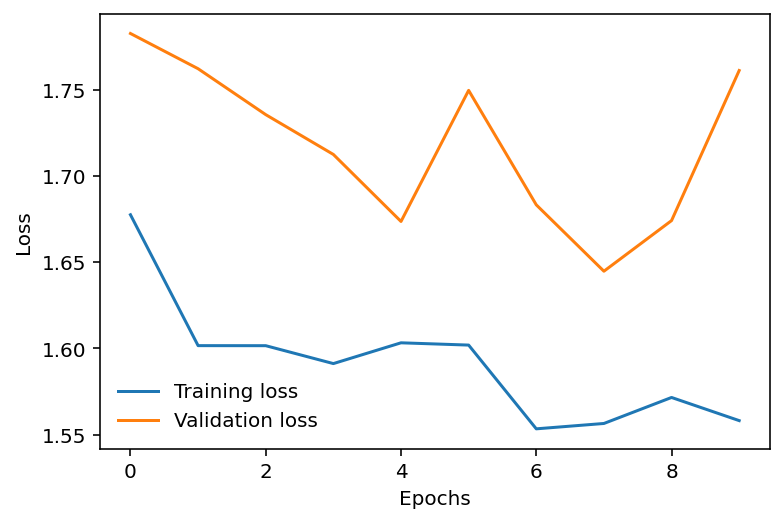

In [ ]:
## Visualize the Train & validation losses :
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [ ]:
## Prediction vs target on the train : 

import plotly.figure_factory as ff

np.random.seed(1)

x = pred_train
y = target_train
hist_data = [x,y]
group_labels = ['output','target'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

In [ ]:
## Plot of soil moisture in train Vs in the whole dataset

import plotly.figure_factory as ff

np.random.seed(1)

x = df['soil_moisture_depth_0.05']
y = target_train
hist_data = [x,y]
group_labels = ['All','Train'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

In [ ]:
## Prediction vs target on the train : 

import plotly.figure_factory as ff

np.random.seed(1)

x = L
y = L1
hist_data = [x,y]
group_labels = ['output','target'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()